Incremental learning for XGBoost model

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
import h5py
import time

In [2]:
# Function to create data with timesteps

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [3]:
# Load the source data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'V_filt':data['V_filt'].ravel(), 'Vel_pc':data['Vel_pc'].ravel(), 
                    'A_filt':data['A_filt'].ravel(), 'T_pc':data['T_pc'].ravel()}) 
df = a_t.merge(m_t, on='Time')
df = df.drop(['Time'], axis=1)

# Preprocessing

arr = df.to_numpy()
n_steps = 300
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))

# Reshape features from 3D to 2D (for input layer)

in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

# Split into train-val-test

x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)   
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)
print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))

xg_train = xgb.DMatrix(X_train, label=Y_train)
xg_val = xgb.DMatrix(X_val, label=Y_val)
xg_test = xgb.DMatrix(x_test, label=y_test)


Features shape, X =  (132099, 300, 4)
Target shape, Y =  (132099,)
After reshaping, X =  (132099, 1200)
Training: (95111, 1200)
Validation: (10568, 1200)
Testing: (26420, 1200)


In [4]:
# Load the second data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5271_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'V_filt':data['V_filt'].ravel(), 'Vel_pc':data['Vel_pc'].ravel(), 
                    'A_filt':data['A_filt'].ravel(), 'T_pc':data['T_pc'].ravel()}) 
df2 = a_t.merge(m_t, on='Time')
df2 = df2.drop(['Time'], axis=1)
# Preprocessing

arr = df2.to_numpy()
n_steps = 300
xdf2, ydf2 = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf2))
print('Target shape, Y = ', np.shape(ydf2))

# Reshape features from 3D to 2D (for input layer)

in_dim = xdf2.shape[1]*xdf2.shape[2]
xdf2 = xdf2.reshape((xdf2.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf2))

# Split into train-val-test

x_train2, x_test2, y_train2, y_test2 = train_test_split(xdf2, ydf2, test_size=0.4, shuffle=False)   
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(x_train2, y_train2, test_size=0.1, shuffle=False)
print("Training:", np.shape(x_train2))
print("Validation:", np.shape(X_val2))
print("Testing:", np.shape(x_test2))

xg_train2 = xgb.DMatrix(X_train2, label=Y_train2)
xg_val2 = xgb.DMatrix(X_val2, label=Y_val2)
xg_test2 = xgb.DMatrix(x_test2, label=y_test2)

Features shape, X =  (75699, 300, 4)
Target shape, Y =  (75699,)
After reshaping, X =  (75699, 1200)
Training: (45419, 1200)
Validation: (4542, 1200)
Testing: (30280, 1200)


In [ ]:
params = {'colsample_bytree':1, 'learning_rate':0.1, 'max_depth':7, 'base_score':0.5, 'objective':'reg:squarederror'}
model = xgb.train(params, xg_train, 500, evals=[(xg_val,'val')], verbose_eval=False, early_stopping_rounds = 40)
model.save_model('transfer_xgb_ss.model')


In [ ]:
params = {'colsample_bytree':1, 'learning_rate':0.1, 'max_depth':7, 'base_score':0.5, 'objective':'reg:squarederror'}
model2 = xgb.train(params, xg_train2, 500, xgb_model='transfer_xgb_ss.model', evals=[(xg_val2,'val')], verbose_eval=False, early_stopping_rounds = 40)

In [ ]:
# Evaluate the model

y_predTrain = model.predict(xg_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain)) 

start_time = time.time()
y_predTest = model.predict(xg_test)
end_time = time.time()
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

y_predTrain = model2.predict(xg_train2)
train_r2_2 = r2_score(Y_train2, y_predTrain)
train_rmse_2 = np.sqrt(mean_squared_error(Y_train2, y_predTrain)) 

start_time = time.time()
y_predTest = model2.predict(xg_test2)
end_time = time.time()
test_r2_2 = r2_score(y_test2, y_predTest)
test_rmse_2 = np.sqrt(mean_squared_error(y_test2, y_predTest))

print("R^2 scores: ", train_r2, test_r2)
print("RMSE: ", train_rmse, test_rmse)


print("R^2 scores: ", train_r2_2, test_r2_2)
print("RMSE: ", train_rmse_2, test_rmse_2)

R^2 scores:  0.9847884589117171 0.8854046173830806
RMSE:  0.01585479506512057 0.049016357959722055
R^2 scores:  0.997750482970493 0.8672363863904576
RMSE:  0.0037616315912409985 0.04263556320552222


In [ ]:
# Save prediction

hf = h5py.File('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/predictions/res300/transfer_xgb_ss.h5', 'w')
hf.create_dataset('y_predTrain', data=y_predTrain)
hf.create_dataset('y_predTest', data=y_predTest)
hf.close()


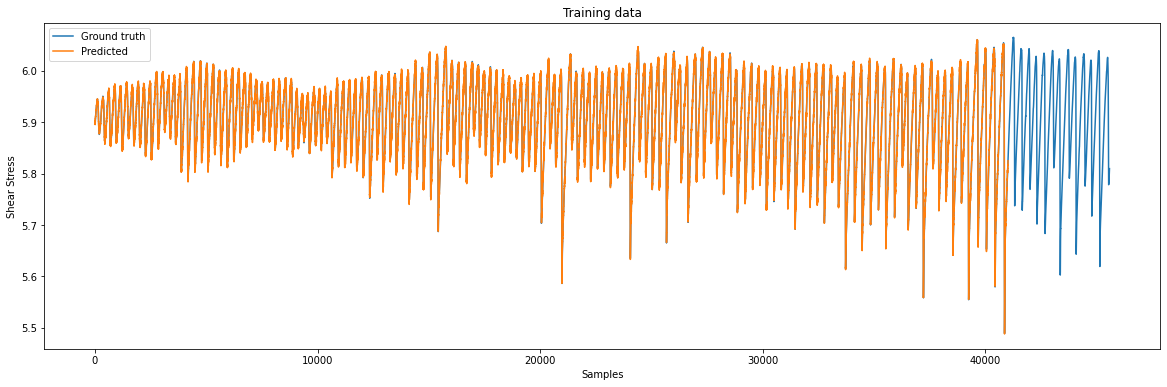

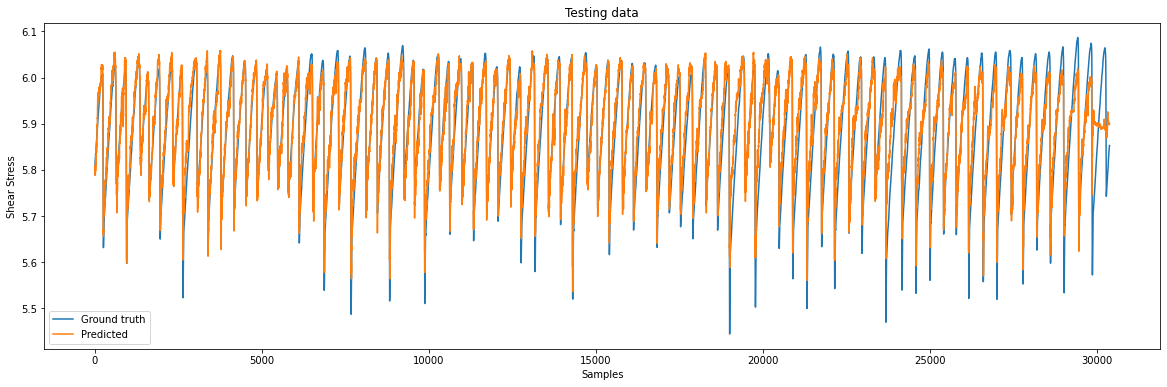

In [ ]:
def results_plot(fig_no, gt, pred, title):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(gt)
  plt.plot(pred)
  plt.xlabel('Samples')
  plt.ylabel('Shear Stress')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, y_train2, y_predTrain, 'Training data')
results_plot(2, y_test2, y_predTest, 'Testing data')